In [1]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import os 
from random import shuffle
from tqdm import tqdm
TRAIN_BDIR = 'D:/graduation project/benign'
TRAIN_MDIR = 'D:/graduation project/malignant'
Test_BDIR = 'D:/graduation project/testb'
Test_MDIR = 'D:/graduation project/testm'

In [2]:
def create_train_Bdata():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_BDIR)):
        path = os.path.join(TRAIN_BDIR,img)
        img = cv2.imread(path)
        training_data.append([img,[1,0]])

    return training_data

In [3]:
def create_train_Mdata():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_MDIR)):
        path = os.path.join(TRAIN_MDIR,img)
        img = cv2.imread(path)
        training_data.append([img,[0,1]])

    return training_data

In [4]:
def create_test_Btest():
    test_data = []
    for img in tqdm(os.listdir(Test_BDIR)):
        path = os.path.join(Test_BDIR,img)
        img = cv2.imread(path)
        test_data.append([img,[1,0]])

    return test_data

In [5]:
def create_test_Mtest():
    test_data = []
    for img in tqdm(os.listdir(Test_MDIR)):
        path = os.path.join(Test_MDIR,img)
        img = cv2.imread(path)
        test_data.append([img,[0,1]])

    return test_data

In [6]:
train_data = create_train_Bdata()

100%|███████████████████████████████████████████████████████████████████████████| 45638/45638 [03:17<00:00, 231.31it/s]


In [7]:
train_data += create_train_Mdata()

100%|███████████████████████████████████████████████████████████████████████████| 14437/14437 [00:47<00:00, 306.74it/s]


In [8]:
test_data = create_test_Btest()

100%|███████████████████████████████████████████████████████████████████████████| 30508/30508 [02:07<00:00, 239.29it/s]


In [9]:
test_data += create_test_Mtest()

100%|█████████████████████████████████████████████████████████████████████████████| 9689/9689 [00:39<00:00, 242.45it/s]


In [10]:
len(train_data)

60075

In [11]:
len(test_data)

40197

In [12]:
#importing other required libraries
import numpy as np
import pandas as pd
from sklearn.utils.multiclass import unique_labels
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.utils import to_categorical
import tensorflow as tf
import datetime


In [13]:
from keras.callbacks import ReduceLROnPlateau
lrr= ReduceLROnPlateau(monitor='val_accuracy',   factor=.01,   patience=3,  min_lr=1e-5)

In [14]:
from keras_efficientnets import EfficientNetB5

In [15]:
for i in range(len(train_data)):
    train_data[i][0] = cv2.resize(train_data[i][0],(75,75))
#for i in range(len(test_data)):
    ##test_data[i][0] = cv2.resize(test_data[i][0],(50,50))
    
train = train_data[:58000]
cv = train_data[58000:]

X = np.array([i[0] for i in train])
Y = np.array([i[1] for i in train])

cv_x = np.array([i[0] for i in cv])
cv_y = np.array([i[1] for i in cv])

#Xnew = np.array([i[0] for i in test_data])


In [16]:
base_model =EfficientNetB5(include_top=False, weights="imagenet", input_shape=(75,75,3),pooling=None,classes=Y.shape[1])

model= Sequential()
model.add(base_model) 
model.add(Flatten()) 

#Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 3, 3, 2048)        28513520  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
Total params: 28,513,520
Trainable params: 28,340,784
Non-trainable params: 172,736
_________________________________________________________________


In [17]:

model.add(Dense(1024,activation=('relu'),input_dim=512))
model.add(Dense(512,activation=('relu'))) 
model.add(Dense(256,activation=('relu'))) 
#model.add(Dropout(.3))
model.add(Dense(128,activation=('relu')))
#model.add(Dropout(.2))
model.add(Dense(2,activation=('softmax'))) 

#Checking the final model summary
model.summary()




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 3, 3, 2048)        28513520  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              18875392  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2

In [18]:
#Defining the parameters
batch_size= 100
epochs=10
learn_rate=.001

In [19]:
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)

In [20]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1 )

val_generator = ImageDataGenerator(rotation_range=2, horizontal_flip=True,zoom_range=.1)
print (train_generator)
#test_generator = ImageDataGenerator(rotation_range=2, horizontal_flip= True,zoom_range=.1)

#Fitting the augmentation defined above to the data
train_generator.fit(X)
val_generator.fit(cv_x)
#test_generator.fit(test_x)

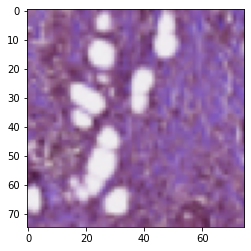

In [21]:
plt.imshow(X[0])

In [65]:
#Compiling the model
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#Training the model
model.fit(train_generator.flow(X, Y, batch_size = batch_size), epochs = epochs, steps_per_epoch = X.shape[0]//batch_size, validation_data = val_generator.flow(cv_x, cv_y, batch_size = batch_size), validation_steps = 200,  callbacks = [tensorboard_callback], verbose = 1)

Epoch 1/10
580/580 [==============================]
loss: 0.7962 - accuracy: 0.8566 - val_loss: 0.9118 - val_accuracy: 0.6590
Epoch 2/10
580/580 [==============================]
loss: 0.5338 - accuracy: 0.8923 - val_loss: 0.7895 - val_accuracy: 0.7967
Epoch 3/10
580/580 [==============================]
loss: 0.4728 - accuracy: 0.9016 - val_loss: 0.7569 - val_accuracy: 0.8870
Epoch 4/10
580/580 [==============================]
loss: 0.4392 - accuracy: 0.9226 - val_loss: 0.6483 - val_accuracy: 0.8947
Epoch 5/10
580/580 [==============================]
loss: 0.3373  - accuracy: 0.9306 - val_loss: 0.5823 - val_accuracy: 0.8989
Epoch 6/10
580/580 [==============================]
loss: 0.3313 - accuracy: 0.9456 - val_loss: 0.5652 - val_accuracy: 0.9021
Epoch 7/10
580/580 [==============================]
loss: 0.2860 - accuracy: 0.9498 - val_loss: 0.5426 - val_accuracy: 0.9044
Epoch 8/10
580/580 [==============================]
loss: 0.2723 - accuracy: 0.9623- val_loss: 0.5265 - val_accuracy:

In [23]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

In [82]:
img=image.load_img('C:/Users/Mohamed Reda/Desktop/model/9291_idx5_x2301_y951_class1.png',target_size=(75,75))

In [83]:
ims=np.asarray(img).astype(np.float32)
ims = ims.reshape(-1, 75, 75, 3)

In [84]:
ynew = model.predict(ims)
ynew

array([[0.35360244, 0.6463976 ]], dtype=float32)

In [85]:
if ynew[0][0] > ynew[0][1]:
    print("Normal")
else:
    print("Affected")

Affected


In [21]:
Xnew = np.asarray(Xnew).astype(np.float32)

NameError: name 'Xnew' is not defined

In [ ]:
for i in range(len(Xnew)):
	print("X=%s, Predicted=%s" % (Xnew[i], ynew[i]))